# DEEP CONVOLUTIONAL GAN
#### All codes are from [carpedm20](https://github.com/carpedm20/DCGAN-tensorflow) github.

In [1]:
import os
import time
import argparse
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy.misc 
from scipy.misc import imread, imresize
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline  
print ("PACKAGES LOADED")

PACKAGES LOADED


# FLAG

In [2]:
# RESET EXISTING FLAG 
tf.app.flags.FLAGS = tf.python.platform.flags._FlagValues()
tf.app.flags._global_parser = argparse.ArgumentParser()
# SET FLAG
flags = tf.app.flags
flags.DEFINE_integer("epoch", 5, "Epoch to train [5]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_integer("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", 64, "The size of batch images [64]")
flags.DEFINE_integer("image_size", 108, "The size of image to use (will be center cropped) [108]")
flags.DEFINE_integer("output_size", 64, "The size of the output images to produce [64]")
flags.DEFINE_integer("c_dim", 3, "Dimension of image color. [3]")
flags.DEFINE_string("dataset", "mnist", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Directory name to save the checkpoints [checkpoint]")
flags.DEFINE_string("sample_dir", "samples", "Directory name to save the image samples [samples]")
flags.DEFINE_boolean("is_crop", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")

# DO TRAIN OR NOT
flags.DEFINE_boolean("is_train", True, "True for training, False for testing [False]")

FLAGS = flags.FLAGS

# LOAD MNIST

In [3]:
def download_mnist(dirpath):
    data_dir = os.path.join(dirpath, 'mnist')
    if os.path.exists(data_dir):
        print('Found MNIST - skip')
        return
    else:
        os.mkdir(data_dir)
    url_base = 'http://yann.lecun.com/exdb/mnist/'
    file_names = ['train-images-idx3-ubyte.gz','train-labels-idx1-ubyte.gz', \
                  't10k-images-idx3-ubyte.gz','t10k-labels-idx1-ubyte.gz']
    for file_name in file_names:
        print (file_name)
        url = (url_base+file_name).format(**locals())
        print(url)
        out_path = os.path.join(data_dir,file_name)
        cmd = ['curl', url, '-o', out_path]
        print('Downloading ', file_name)
        subprocess.call(cmd)
        cmd = ['gzip', '-d', out_path]
        print('Decompressing ', file_name)
        subprocess.call(cmd)
def load_mnist():
    data_dir = os.path.join("./data", 'mnist')
    fd = open(os.path.join(data_dir,'train-images-idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trX = loaded[16:].reshape((60000,28,28,1)).astype(np.float)
    fd = open(os.path.join(data_dir,'train-labels-idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    trY = loaded[8:].reshape((60000)).astype(np.float)
    fd = open(os.path.join(data_dir,'t10k-images-idx3-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teX = loaded[16:].reshape((10000,28,28,1)).astype(np.float)
    fd = open(os.path.join(data_dir,'t10k-labels-idx1-ubyte'))
    loaded = np.fromfile(file=fd,dtype=np.uint8)
    teY = loaded[8:].reshape((10000)).astype(np.float)
    trY = np.asarray(trY)
    teY = np.asarray(teY)
    X = np.concatenate((trX, teX), axis=0)
    y = np.concatenate((trY, teY), axis=0)
    # SHUFFLE 
    seed = 547
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(y)
    y_vec = np.zeros((len(y), 10), dtype=np.float)
    for i, label in enumerate(y):
        y_vec[i,y[i]] = 1.0
    return X/255., y_vec

In [4]:
# GET MNIST
download_mnist('./data')

Found MNIST - skip


# SUMMAMRIES

In [5]:
if 0:
    image_summary = tf.image_summary
    scalar_summary = tf.scalar_summary
    histogram_summary = tf.histogram_summary
    merge_summary = tf.merge_summary
    SummaryWriter = tf.train.SummaryWriter
else:
    image_summary = tf.summary.image
    scalar_summary = tf.summary.scalar
    histogram_summary = tf.summary.histogram
    merge_summary = tf.summary.merge
    SummaryWriter = tf.summary.FileWriter

# LEAKY RELU

In [6]:
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)
print ("LEAKY RELU")

LEAKY RELU


# BATCH NORMALIZATION

In [7]:
class batch_norm(object):
    def __init__(self, epsilon=1e-5, momentum = 0.9, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon  = epsilon
            self.momentum = momentum
            self.name = name
    def __call__(self, x, train=True):
        return tf.contrib.layers.batch_norm(x,
                                            decay=self.momentum, 
                                            updates_collections=None,
                                            epsilon=self.epsilon,
                                            scale=True,
                                            is_training=train,
                                            scope=self.name)
print ("BATCH NORMALIZATION CLASS")

BATCH NORMALIZATION CLASS


# AFFINE MAPPING

In [8]:
def linear(input_, output_size, scope=None, stddev=0.02, init_bias=0.0, with_w=False):
    shape = input_.get_shape().as_list()

    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size], 
            initializer=tf.constant_initializer(init_bias))
        if with_w:
            return tf.matmul(input_, matrix) + bias, matrix, bias
        else:
            return tf.matmul(input_, matrix) + bias
print ("AFFINE MAPPING FUNCTION")

AFFINE MAPPING FUNCTION


# CONCATENATE CONDITIONING VECTOR

In [9]:
def conv_cond_concat(x, y):
    x_shapes = x.get_shape()
    y_shapes = y.get_shape()
    return tf.concat(3, [x, y*tf.ones([x_shapes[0], x_shapes[1], x_shapes[2], y_shapes[3]])])
print ("CONV CONCAT FUNCTION")

CONV CONCAT FUNCTION


# CONVOLUTION

In [10]:
def conv2d(input_, output_dim, 
           k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
           name="conv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                            initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')
        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())
        return conv
print ("CONVOLUTION FUNCTION")

CONVOLUTION FUNCTION


# DECONVOLUTION

In [11]:
def deconv2d(input_, output_shape,
             k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
             name="deconv2d", with_w=False):
    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], input_.get_shape()[-1]],
                            initializer=tf.random_normal_initializer(stddev=stddev))
        try:
            deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape,
                                strides=[1, d_h, d_w, 1])
        # Support for verisons of TensorFlow before 0.7.0
        except AttributeError:
            deconv = tf.nn.deconv2d(input_, w, output_shape=output_shape,
                                strides=[1, d_h, d_w, 1])
        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())
        if with_w:
            return deconv, w, biases
        else:
            return deconv
print ("DECONVOLUTION FUNCTION")

DECONVOLUTION FUNCTION


# VISUALIZE

In [12]:
def make_gif(images, fname, duration=2, true_image=False):
    import moviepy.editor as mpy
    def make_frame(t):
        try:
            x = images[int(len(images)/duration*t)]
        except:
            x = images[-1]
        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x+1)/2*255).astype(np.uint8)
    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.write_gif(fname, fps = len(images) / duration)
def visualize(sess, dcgan, config, option):
    if option == 0:
        z_sample = np.random.uniform(-0.5, 0.5, size=(config.batch_size, dcgan.z_dim))
        samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample})
        save_images(samples, [8, 8], './samples/test_%s.png' % strftime("%Y-%m-%d %H:%M:%S", gmtime()))
    elif option == 1:
        values = np.arange(0, 1, 1./config.batch_size)
        nrsave = 10
        for idx in xrange(nrsave): # SAVE 10 IMAGES
            z_sample = np.zeros([config.batch_size, dcgan.z_dim])
            for kdx, z in enumerate(z_sample):
                z[idx] = values[kdx]
            y = np.random.choice(10, config.batch_size)
            y_one_hot = np.zeros((config.batch_size, 10))
            y_one_hot[np.arange(config.batch_size), y] = 1
            # ACTUALLY, SAMPLE HERE
            feeds_sample = {dcgan.z: z_sample, dcgan.y: y_one_hot}
            samples = sess.run(dcgan.sampler, feed_dict=feeds_sample)
            savename = './samples/test_arange_%03d.png' % (idx)
            save_images(samples, [8, 8], savename)
            # PLOT
            print ('y: %s' % (y))
            currsampleimg = imread(savename)
            plt.imshow(currsampleimg)
            plt.title(savename)
            plt.show()
            
            print(" [%3d/%3d] savename: %s" % (idx, nrsave , savename))
    elif option == 2:
        values = np.arange(0, 1, 1./config.batch_size)
        for idx in [random.randint(0, 99) for _ in xrange(100)]:
            print(" [*] %d" % idx)
            z = np.random.uniform(-0.2, 0.2, size=(dcgan.z_dim))
            z_sample = np.tile(z, (config.batch_size, 1))
            for kdx, z in enumerate(z_sample):
                z[idx] = values[kdx]

            y = np.random.choice(10, config.batch_size)
            y_one_hot = np.zeros((config.batch_size, 10))
            y_one_hot[np.arange(config.batch_size), y] = 1
            samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
            try:
                make_gif(samples, './samples/test_gif_%s.gif' % (idx))
            except:
                save_images(samples, [8, 8], './samples/test_%s.png' % strftime("%Y-%m-%d %H:%M:%S", gmtime()))
    elif option == 3:
        values = np.arange(0, 1, 1./config.batch_size)
        for idx in xrange(100):
            print(" [*] %d" % idx)
            z_sample = np.zeros([config.batch_size, dcgan.z_dim])
            for kdx, z in enumerate(z_sample):
                z[idx] = values[kdx]
            samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample})
            make_gif(samples, './samples/test_gif_%s.gif' % (idx))
    elif option == 4:
        image_set = []
        values = np.arange(0, 1, 1./config.batch_size)
        for idx in xrange(100):
            print(" [*] %d" % idx)
            z_sample = np.zeros([config.batch_size, dcgan.z_dim])
            for kdx, z in enumerate(z_sample): z[idx] = values[kdx]
            image_set.append(sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample}))
            make_gif(image_set[-1], './samples/test_gif_%s.gif' % (idx))
        new_image_set = [merge(np.array([images[idx] for images in image_set]), [10, 10]) \
            for idx in range(64) + range(63, -1, -1)]
        make_gif(new_image_set, './samples/test_gif_merged.gif', duration=8)

# OTHER HELPER FUNCTIONS

In [13]:
def save_images(images, size, image_path):
    img2save = inverse_transform(images)
    imsave(img2save, size, image_path)
    return img2save
def imsave(images, size, path):
    return scipy.misc.imsave(path, merge(images, size))
def inverse_transform(images):
    return (images+1.)/2.
def merge_images(images, size):
    return inverse_transform(images)
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

# DEEP CONVOLUTIONAL CGAN

In [14]:
class DCGAN(object):
    """ 
        ***********************************************************
                            CONSTRUCTOR
        ***********************************************************
    """     
    def __init__(self, sess, image_size=108, is_crop=True,
                batch_size=64, sample_size=64, output_size=64,
                y_dim=None, z_dim=100, gf_dim=64, df_dim=64,
                gfc_dim=1024, dfc_dim=1024, c_dim=3, dataset_name='default',
                checkpoint_dir=None, sample_dir=None):
        # PARSE INPUT ARGUMENTS
        self.sess         = sess
        self.is_crop      = is_crop
        self.is_grayscale = (c_dim == 1)
        self.batch_size   = batch_size
        self.image_size   = image_size
        self.sample_size  = sample_size
        self.output_size  = output_size
        self.y_dim        = y_dim # CONDITIONING VECTOR 
        self.z_dim        = z_dim
        self.gf_dim       = gf_dim
        self.df_dim       = df_dim
        self.gfc_dim      = gfc_dim
        self.dfc_dim      = dfc_dim
        self.c_dim        = c_dim
        self.dataset_name = dataset_name
        self.checkpoint_dir = checkpoint_dir
        # BATCH NORMALIZATION
        self.d_bn1        = batch_norm(name='d_bn1')
        self.d_bn2        = batch_norm(name='d_bn2')
        if not self.y_dim:
            self.d_bn3 = batch_norm(name='d_bn3')
        self.g_bn0 = batch_norm(name='g_bn0')
        self.g_bn1 = batch_norm(name='g_bn1')
        self.g_bn2 = batch_norm(name='g_bn2')
        if not self.y_dim:
            self.g_bn3 = batch_norm(name='g_bn3')
        # BUILD MODEL
        self.build_model() 
    """ 
        ***********************************************************
                            BUILD DCGAN MODEL
        ***********************************************************
    """ 
    def build_model(self): # DEFINE G, D, AND LOSSES
        self.y= tf.placeholder(tf.float32, [self.batch_size, self.y_dim], name='y')
        _imgsize = [self.batch_size, self.output_size, self.output_size, self.c_dim]
        self.images = tf.placeholder(tf.float32, _imgsize, name='real_images')
        _simgsize = [self.sample_size] + [self.output_size, self.output_size, self.c_dim]
        self.sample_images= tf.placeholder(tf.float32, _simgsize, name='sample_images')
        self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z') 
        self.z_sum = histogram_summary("z", self.z)
        self.G = self.generator(self.z, self.y)
        self.D, self.D_logits  = self.discriminator(self.images, self.y, reuse=False)
        self.sampler = self.sampler(self.z, self.y)
        self.D_, self.D_logits_ = self.discriminator(self.G, self.y, reuse=True)
        # SUMMARIES
        self.d_sum = histogram_summary("d", self.D)
        self.d__sum = histogram_summary("d_", self.D_)
        self.G_sum = image_summary("G", self.G)
        # LOSS FUNCTIONS
        self.d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(self.D_logits, tf.ones_like(self.D)))
        self.d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(self.D_logits_, tf.zeros_like(self.D_)))
        self.g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(self.D_logits_, tf.ones_like(self.D_)))
        self.d_loss_real_sum = scalar_summary("d_loss_real", self.d_loss_real)
        self.d_loss_fake_sum = scalar_summary("d_loss_fake", self.d_loss_fake)                                 
        self.d_loss = self.d_loss_real + self.d_loss_fake
        self.g_loss_sum = scalar_summary("g_loss", self.g_loss)
        self.d_loss_sum = scalar_summary("d_loss", self.d_loss)
        # VARIABLES
        t_vars = tf.trainable_variables()
        self.d_vars = [var for var in t_vars if 'd_' in var.name]
        self.g_vars = [var for var in t_vars if 'g_' in var.name]
        # SAVER
        self.saver = tf.train.Saver()
    """ 
        ***********************************************************
                            GENERATOR
        ***********************************************************
    """ 
    def generator(self, z, y=None):
        with tf.variable_scope("generator") as scope:
            s = self.output_size
            s2, s4 = int(s/2), int(s/4) 
            yb = tf.reshape(y, [self.batch_size, 1, 1, self.y_dim])
            z = tf.concat(1, [z, y]) # <= CONCATENATE 
            h0 = tf.nn.relu(self.g_bn0(linear(z, self.gfc_dim, 'g_h0_lin')))
            h0 = tf.concat(1, [h0, y])
            h1 = tf.nn.relu(self.g_bn1(linear(h0, self.gf_dim*2*s4*s4, 'g_h1_lin')))
            h1 = tf.reshape(h1, [self.batch_size, s4, s4, self.gf_dim * 2])
            h1 = conv_cond_concat(h1, yb)
            h2 = tf.nn.relu(self.g_bn2(deconv2d(h1, [self.batch_size, s2, s2, self.gf_dim * 2], name='g_h2')))
            h2 = conv_cond_concat(h2, yb)
            out = tf.nn.sigmoid(deconv2d(h2, [self.batch_size, s, s, self.c_dim], name='g_h3'))
            return out
    """ 
        ***********************************************************
                            DISCRIMINATOR
        ***********************************************************
    """
    def discriminator(self, image, y=None, reuse=False):
        with tf.variable_scope("discriminator") as scope:
            if reuse:
                scope.reuse_variables()

            yb = tf.reshape(y, [self.batch_size, 1, 1, self.y_dim])
            x = conv_cond_concat(image, yb) # CONCATENATE
            h0 = lrelu(conv2d(x, self.c_dim + self.y_dim, name='d_h0_conv'))
            h0 = conv_cond_concat(h0, yb)
            h1 = lrelu(self.d_bn1(conv2d(h0, self.df_dim + self.y_dim, name='d_h1_conv')))
            h1 = tf.reshape(h1, [self.batch_size, -1])            
            h1 = tf.concat(1, [h1, y])
            h2 = lrelu(self.d_bn2(linear(h1, self.dfc_dim, 'd_h2_lin')))
            h2 = tf.concat(1, [h2, y])
            h3 = linear(h2, 1, 'd_h3_lin')
            out = tf.nn.sigmoid(h3)
            return out, h3
    """ 
        ***********************************************************
                            SAMPLER 
        ***********************************************************
    """ 
    def sampler(self, z, y=None):
        with tf.variable_scope("generator") as scope:
            scope.reuse_variables()
            s = self.output_size
            s2, s4 = int(s/2), int(s/4)
            yb = tf.reshape(y, [self.batch_size, 1, 1, self.y_dim])
            z = tf.concat(1, [z, y])
            h0 = tf.nn.relu(self.g_bn0(linear(z, self.gfc_dim, 'g_h0_lin')))
            h0 = tf.concat(1, [h0, y])
            h1 = tf.nn.relu(self.g_bn1(linear(h0, self.gf_dim*2*s4*s4, 'g_h1_lin'), train=False))
            h1 = tf.reshape(h1, [self.batch_size, s4, s4, self.gf_dim * 2])
            h1 = conv_cond_concat(h1, yb)
            h2 = tf.nn.relu(self.g_bn2(deconv2d(h1, [self.batch_size, s2, s2, self.gf_dim * 2], name='g_h2'), train=False))
            h2 = conv_cond_concat(h2, yb)
            out = tf.nn.sigmoid(deconv2d(h2, [self.batch_size, s, s, self.c_dim], name='g_h3'))
            return out
    """ 
        ***********************************************************
                            TRAIN 
        ***********************************************************
    """ 
    def train(self, config):
        # LOAD MNIST
        data_X, data_y = load_mnist()
        # OPTIMIZER
        d_optim = tf.train.AdamOptimizer(config.learning_rate, beta1=config.beta1) \
                          .minimize(self.d_loss, var_list=self.d_vars)
        g_optim = tf.train.AdamOptimizer(config.learning_rate, beta1=config.beta1) \
                          .minimize(self.g_loss, var_list=self.g_vars)
        if 0: # OLDER VERSION
            tf.initialize_all_variables().run()
        else:
            init_op = tf.global_variables_initializer()
            self.sess.run(init_op)
        self.g_sum = merge_summary([self.z_sum, self.d__sum,
            self.G_sum, self.d_loss_fake_sum, self.g_loss_sum])
        self.d_sum = merge_summary([self.z_sum, self.d_sum, self.d_loss_real_sum, self.d_loss_sum])
        self.writer = SummaryWriter("./logs", self.sess.graph)
        # RANDOM VECTORS
        sample_z = np.random.uniform(-1, 1, size=(self.sample_size , self.z_dim))
        # SAMPLE IMAGES
        sample_images = data_X[0:self.sample_size]
        sample_labels = data_y[0:self.sample_size]
        print ("sample_labels: %s" % (np.argmax(sample_labels, axis=1)))
        # START TRAINING
        counter = 1
        start_time = time.time()
        for epoch in xrange(config.epoch): 
            # FOR EACH EPOCH
            batch_idxs = min(len(data_X), config.train_size) // config.batch_size
            randpermlist = np.random.permutation(min(len(data_X), config.train_size))
            for idx in xrange(0, batch_idxs):
                # FOR EACH ITERATION 
                batch_idx = randpermlist[idx*config.batch_size:(idx+1)*config.batch_size]
                batch_images = data_X[batch_idx]
                batch_labels  = data_y[batch_idx]
                batch_z = np.random.uniform(-1, 1, [config.batch_size, self.z_dim]) \
                            .astype(np.float32)
                
                # Update D network
                _, summary_str = self.sess.run([d_optim, self.d_sum],
                    feed_dict={ self.images: batch_images, self.z: batch_z, self.y:batch_labels })
                self.writer.add_summary(summary_str, counter)

                # Update G network
                _, summary_str = self.sess.run([g_optim, self.g_sum],
                    feed_dict={ self.z: batch_z, self.y:batch_labels })
                self.writer.add_summary(summary_str, counter)

                # Run g_optim twice to make sure that d_loss does not go to zero (different from paper)
                _, summary_str = self.sess.run([g_optim, self.g_sum],
                    feed_dict={ self.z: batch_z, self.y:batch_labels })
                self.writer.add_summary(summary_str, counter)

                errD_fake = self.d_loss_fake.eval({self.z: batch_z, self.y:batch_labels})
                errD_real = self.d_loss_real.eval({self.images: batch_images, self.y:batch_labels})
                errG = self.g_loss.eval({self.z: batch_z, self.y:batch_labels})
                
                counter += 1
                if np.mod(counter, 100) == 1:
                    print("Epoch: [%2d/%3d] [%4d/%4d] time: %4.4f, d_loss: %.8f, g_loss: %.8f" \
                        % (epoch, config.epoch, idx, batch_idxs,
                            time.time() - start_time, errD_fake+errD_real, errG))
                # SAMPLE IMAGES
                if np.mod(counter, 1000) == 1:
                    samples, d_loss, g_loss = self.sess.run(
                        [self.sampler, self.d_loss, self.g_loss],
                        feed_dict={self.z: sample_z, self.images: sample_images, self.y:sample_labels}
                    )
                    imgname = './{}/train_{:02d}_{:04d}.png'.format(config.sample_dir, epoch, idx)
                    save_images(samples, [8, 8], imgname)
                    currsampleimg = imread(imgname)
                    plt.imshow(currsampleimg)
                    plt.title(imgname)
                    plt.show()
                    print("[Sample] d_loss: %.8f, g_loss: %.8f" % (d_loss, g_loss))
                if np.mod(counter, 1000) == 2:
                    self.save(config.checkpoint_dir, counter)
    """ 
        ***********************************************************
                            SAVE 
        ***********************************************************
    """ 
    def save(self, checkpoint_dir, step):
        model_name = "DCGAN.model"
        model_dir = "%s_%s_%s" % (self.dataset_name, self.batch_size, self.output_size)
        checkpoint_dir = os.path.join(checkpoint_dir, model_dir)
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        self.saver.save(self.sess,
                        os.path.join(checkpoint_dir, model_name),
                        global_step=step)
    """ 
        ***********************************************************
                            LOAD
        ***********************************************************
    """ 
    def load(self, checkpoint_dir):
        print(" [*] Reading checkpoints...")
        model_dir = "%s_%s_%s" % (self.dataset_name, self.batch_size, self.output_size)
        checkpoint_dir = os.path.join(checkpoint_dir, model_dir)
        ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
        if ckpt and ckpt.model_checkpoint_path:
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
            print(" [*] Success to read {}".format(ckpt_name))
            return True
        else:
            print(" [*] Failed to find a checkpoint")
            return False

# RUN

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


sample_labels: [7 5 1 0 3 2 5 2 6 8 3 6 4 0 8 3 2 8 6 2 1 2 0 1 4 4 0 2 4 4 2 3 2 2 8 9 4
 0 0 3 2 0 6 5 3 0 5 2 0 3 7 9 6 1 2 3 9 5 5 3 3 7 0 8]
Epoch: [  0/  5] [  99/1093] time: 5.6326, d_loss: 1.39681959, g_loss: 0.67954755
Epoch: [  0/  5] [ 199/1093] time: 9.3073, d_loss: 1.40584350, g_loss: 0.69132447
Epoch: [  0/  5] [ 299/1093] time: 12.9781, d_loss: 1.39278543, g_loss: 0.68581235
Epoch: [  0/  5] [ 399/1093] time: 16.6589, d_loss: 1.39356613, g_loss: 0.68571073
Epoch: [  0/  5] [ 499/1093] time: 20.3208, d_loss: 1.40585017, g_loss: 0.67941868
Epoch: [  0/  5] [ 599/1093] time: 23.9645, d_loss: 1.39900684, g_loss: 0.67104626
Epoch: [  0/  5] [ 699/1093] time: 27.7309, d_loss: 1.40705955, g_loss: 0.66623127
Epoch: [  0/  5] [ 799/1093] time: 31.4058, d_loss: 1.39976585, g_loss: 0.68122232
Epoch: [  0/  5] [ 899/1093] time: 35.0723, d_loss: 1.39689159, g_loss: 0.66573793
Epoch: [  0/  5] [ 999/1093] time: 38.7327, d_loss: 1.39049649, g_loss: 0.67518085


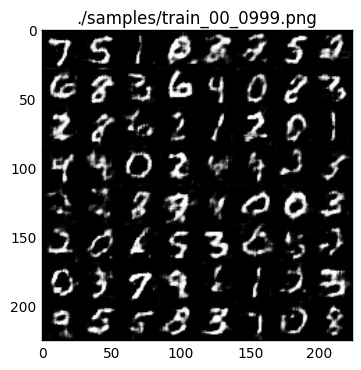

[Sample] d_loss: 1.38779414, g_loss: 0.69491696
Epoch: [  1/  5] [   6/1093] time: 44.0258, d_loss: 1.39285994, g_loss: 0.66654932
Epoch: [  1/  5] [ 106/1093] time: 47.6966, d_loss: 1.40127230, g_loss: 0.66113865
Epoch: [  1/  5] [ 206/1093] time: 51.3555, d_loss: 1.38589334, g_loss: 0.67303628
Epoch: [  1/  5] [ 306/1093] time: 55.0313, d_loss: 1.38842106, g_loss: 0.67810953
Epoch: [  1/  5] [ 406/1093] time: 58.7366, d_loss: 1.39854085, g_loss: 0.67466438
Epoch: [  1/  5] [ 506/1093] time: 62.3957, d_loss: 1.38301325, g_loss: 0.67831278
Epoch: [  1/  5] [ 606/1093] time: 66.0741, d_loss: 1.37977409, g_loss: 0.67931914
Epoch: [  1/  5] [ 706/1093] time: 69.7522, d_loss: 1.38833320, g_loss: 0.67881453
Epoch: [  1/  5] [ 806/1093] time: 73.4589, d_loss: 1.39179230, g_loss: 0.66973525
Epoch: [  1/  5] [ 906/1093] time: 77.1611, d_loss: 1.38392496, g_loss: 0.67679495


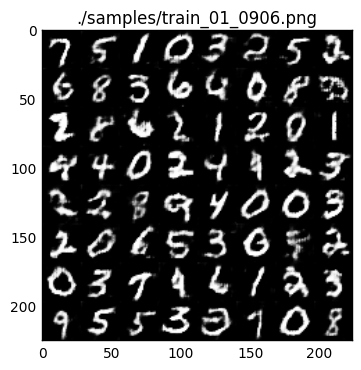

[Sample] d_loss: 1.37549019, g_loss: 0.70284820
Epoch: [  1/  5] [1006/1093] time: 82.3697, d_loss: 1.38076699, g_loss: 0.68531495
Epoch: [  2/  5] [  13/1093] time: 86.0712, d_loss: 1.39091659, g_loss: 0.67520845
Epoch: [  2/  5] [ 113/1093] time: 89.7681, d_loss: 1.38824427, g_loss: 0.67936009
Epoch: [  2/  5] [ 213/1093] time: 93.4674, d_loss: 1.39518678, g_loss: 0.67252076
Epoch: [  2/  5] [ 313/1093] time: 97.1697, d_loss: 1.38838506, g_loss: 0.67373824
Epoch: [  2/  5] [ 413/1093] time: 100.8746, d_loss: 1.39019871, g_loss: 0.68177509
Epoch: [  2/  5] [ 513/1093] time: 104.5694, d_loss: 1.39026070, g_loss: 0.67228973
Epoch: [  2/  5] [ 613/1093] time: 108.2605, d_loss: 1.38759995, g_loss: 0.67867935
Epoch: [  2/  5] [ 713/1093] time: 111.9368, d_loss: 1.38952327, g_loss: 0.67632544
Epoch: [  2/  5] [ 813/1093] time: 115.6495, d_loss: 1.39309192, g_loss: 0.67472696


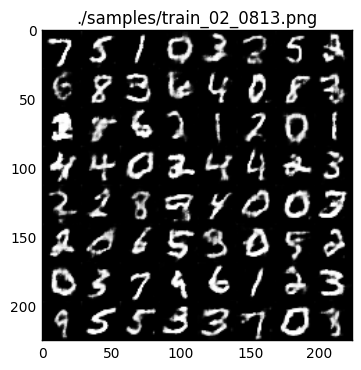

[Sample] d_loss: 1.37413204, g_loss: 0.70151043
Epoch: [  2/  5] [ 913/1093] time: 120.8269, d_loss: 1.39923763, g_loss: 0.66764867
Epoch: [  2/  5] [1013/1093] time: 124.5307, d_loss: 1.38455164, g_loss: 0.67749238
Epoch: [  3/  5] [  20/1093] time: 128.2091, d_loss: 1.38193429, g_loss: 0.68389457
Epoch: [  3/  5] [ 120/1093] time: 131.9135, d_loss: 1.39118540, g_loss: 0.68290448
Epoch: [  3/  5] [ 220/1093] time: 135.6102, d_loss: 1.39396477, g_loss: 0.67383492
Epoch: [  3/  5] [ 320/1093] time: 139.3141, d_loss: 1.37095487, g_loss: 0.68591022
Epoch: [  3/  5] [ 420/1093] time: 143.0041, d_loss: 1.38746500, g_loss: 0.67465079
Epoch: [  3/  5] [ 520/1093] time: 146.6806, d_loss: 1.39631927, g_loss: 0.67267340
Epoch: [  3/  5] [ 620/1093] time: 150.3502, d_loss: 1.39209330, g_loss: 0.67408830
Epoch: [  3/  5] [ 720/1093] time: 154.0341, d_loss: 1.37573183, g_loss: 0.67612338


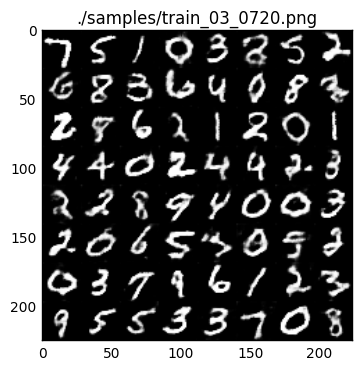

[Sample] d_loss: 1.38559246, g_loss: 0.68870550
Epoch: [  3/  5] [ 820/1093] time: 159.3257, d_loss: 1.38519216, g_loss: 0.68571299
Epoch: [  3/  5] [ 920/1093] time: 163.0249, d_loss: 1.38371992, g_loss: 0.68115002
Epoch: [  3/  5] [1020/1093] time: 166.7063, d_loss: 1.39028156, g_loss: 0.67828381
Epoch: [  4/  5] [  27/1093] time: 170.3844, d_loss: 1.38923717, g_loss: 0.68173003
Epoch: [  4/  5] [ 127/1093] time: 174.0620, d_loss: 1.40317249, g_loss: 0.66658509
Epoch: [  4/  5] [ 227/1093] time: 177.7644, d_loss: 1.38474703, g_loss: 0.67707336
Epoch: [  4/  5] [ 327/1093] time: 181.4360, d_loss: 1.39687073, g_loss: 0.67108440
Epoch: [  4/  5] [ 427/1093] time: 185.1327, d_loss: 1.38375986, g_loss: 0.67517579
Epoch: [  4/  5] [ 527/1093] time: 188.8403, d_loss: 1.39226103, g_loss: 0.67841756
Epoch: [  4/  5] [ 627/1093] time: 192.6059, d_loss: 1.39145780, g_loss: 0.68185061


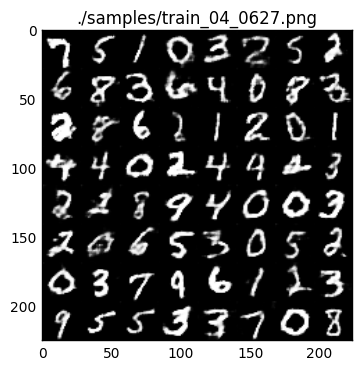

[Sample] d_loss: 1.38742900, g_loss: 0.69264972
Epoch: [  4/  5] [ 727/1093] time: 197.9133, d_loss: 1.38755512, g_loss: 0.68244290
Epoch: [  4/  5] [ 827/1093] time: 201.5867, d_loss: 1.38650298, g_loss: 0.67993999
Epoch: [  4/  5] [ 927/1093] time: 205.2950, d_loss: 1.39167166, g_loss: 0.67634118
Epoch: [  4/  5] [1027/1093] time: 209.0380, d_loss: 1.37349474, g_loss: 0.68911970
y: [5 0 4 9 3 7 4 5 5 5 8 5 5 5 2 2 6 4 8 9 1 7 6 1 6 5 9 4 8 4 3 5 0 3 3 2 6
 4 0 7 2 3 8 4 0 0 9 8 9 4 6 0 8 9 7 9 8 1 7 9 8 3 4 6]


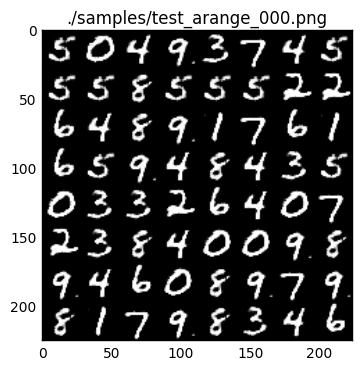

 [  0/ 10] savename: ./samples/test_arange_000.png
y: [1 6 9 3 1 1 2 6 5 8 6 9 1 6 4 3 5 0 1 8 2 8 0 6 9 4 0 7 5 0 6 6 6 1 3 4 6
 8 6 3 1 7 3 7 9 1 7 7 0 7 5 4 0 9 6 4 0 8 7 3 7 2 6 7]


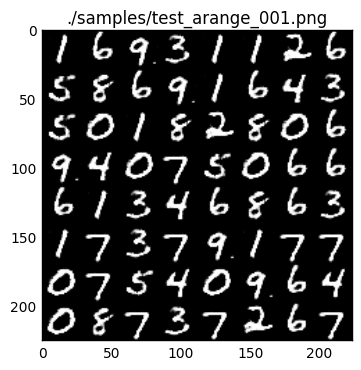

 [  1/ 10] savename: ./samples/test_arange_001.png
y: [3 2 8 1 0 5 5 5 7 0 6 3 1 5 0 5 1 5 7 7 6 3 5 2 4 5 8 2 0 0 2 9 7 4 1 5 6
 3 6 1 7 8 4 3 1 6 4 5 3 3 9 8 0 3 9 3 6 9 9 5 5 6 7 3]


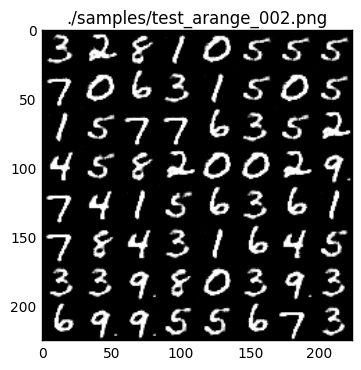

 [  2/ 10] savename: ./samples/test_arange_002.png
y: [1 4 3 3 3 6 3 4 0 4 3 6 1 2 0 7 3 3 0 7 3 3 0 1 0 4 2 0 3 5 0 2 6 0 2 3 4
 5 6 3 6 0 4 5 0 8 4 3 3 2 0 1 9 0 0 2 7 7 3 4 8 8 7 0]


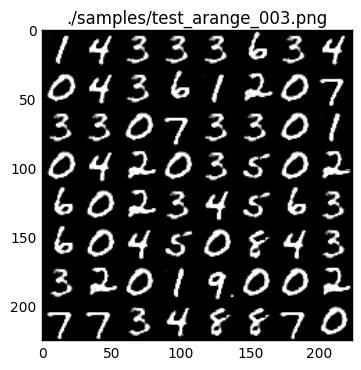

 [  3/ 10] savename: ./samples/test_arange_003.png
y: [3 7 0 5 0 1 6 8 4 7 1 0 6 2 4 7 9 8 1 9 3 2 0 3 2 1 5 1 5 4 5 0 6 8 4 5 8
 1 7 9 3 8 1 5 9 8 6 9 5 3 9 6 3 1 0 7 7 9 7 2 5 3 3 1]


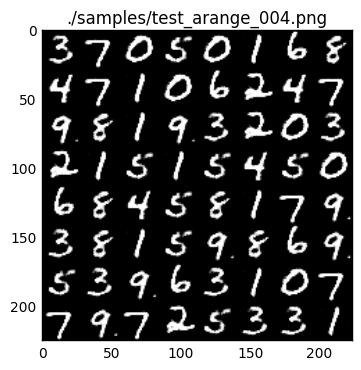

 [  4/ 10] savename: ./samples/test_arange_004.png
y: [4 8 1 5 2 7 6 6 5 9 3 4 0 5 3 5 0 0 2 2 8 1 5 2 0 0 4 3 7 0 4 8 0 6 2 0 2
 5 0 7 4 1 6 9 8 1 7 0 0 4 3 1 7 1 4 7 6 9 1 5 5 0 3 7]


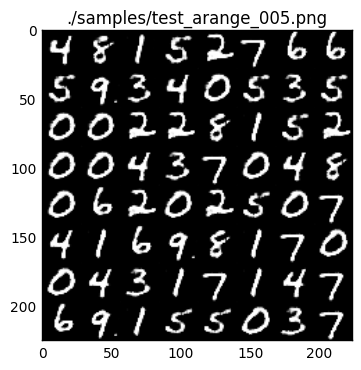

 [  5/ 10] savename: ./samples/test_arange_005.png
y: [2 5 4 7 5 9 1 9 6 5 4 4 7 4 9 4 3 4 5 2 3 6 5 8 6 5 9 8 3 6 0 8 9 9 6 0 3
 4 4 6 4 8 7 9 7 8 9 2 9 5 2 6 3 7 8 1 0 4 2 3 0 3 4 8]


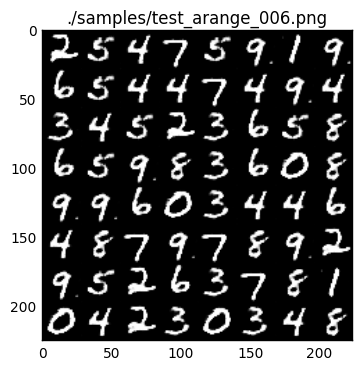

 [  6/ 10] savename: ./samples/test_arange_006.png
y: [6 6 7 4 0 5 4 7 6 9 3 3 2 2 2 8 3 8 0 2 5 4 6 1 6 7 2 0 1 2 2 1 5 3 2 8 1
 8 4 8 8 9 2 0 9 1 7 9 1 2 2 7 7 9 5 9 6 8 0 6 3 5 4 0]


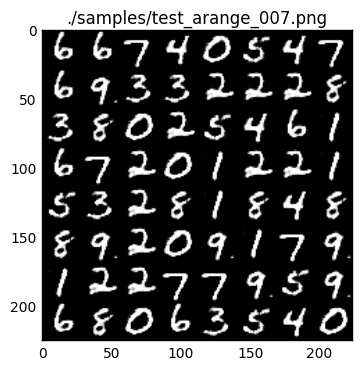

 [  7/ 10] savename: ./samples/test_arange_007.png
y: [9 9 4 0 7 1 8 2 1 8 7 5 2 9 3 4 4 7 3 3 0 9 3 8 3 8 9 9 8 0 6 9 5 0 1 1 6
 4 2 0 2 6 9 4 9 9 9 7 1 5 8 5 8 5 7 4 8 5 4 0 6 8 9 2]


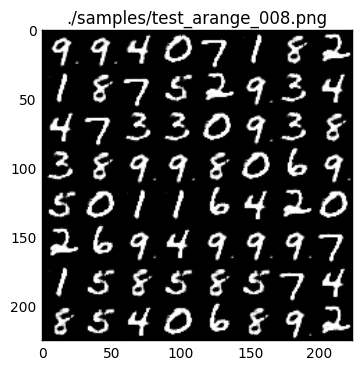

 [  8/ 10] savename: ./samples/test_arange_008.png
y: [1 0 2 7 3 3 5 5 9 9 2 7 8 6 1 1 7 9 2 8 2 2 3 9 5 1 8 1 0 3 7 0 0 2 3 8 7
 7 2 0 8 0 4 7 1 7 5 1 7 9 4 6 0 8 5 2 5 9 2 4 4 2 3 9]


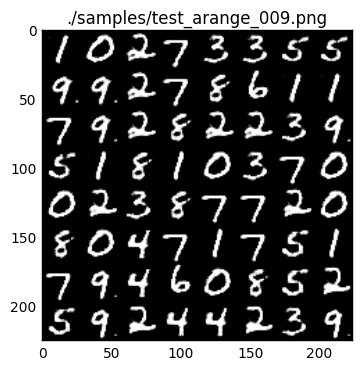

 [  9/ 10] savename: ./samples/test_arange_009.png


In [15]:
# MAKE FOLDERS, IF NECESSARY
if not os.path.exists(FLAGS.checkpoint_dir):
    os.makedirs(FLAGS.checkpoint_dir)
if not os.path.exists(FLAGS.sample_dir):
    os.makedirs(FLAGS.sample_dir)
with tf.Session() as sess: 
    # CONTRUCT DCGAN CLASS
    dcgan = DCGAN(sess,
                  image_size=FLAGS.image_size,
                  batch_size=FLAGS.batch_size,
                  y_dim=10, # <= CONDITION VECTOR
                  output_size=28,
                  c_dim=1,
                  dataset_name=FLAGS.dataset,
                  is_crop=FLAGS.is_crop,
                  checkpoint_dir=FLAGS.checkpoint_dir,
                  sample_dir=FLAGS.sample_dir)
    # TRAIN OR LOAD EXISTING NETWORKS
    if FLAGS.is_train:
        dcgan.train(FLAGS)
    else:
        dcgan.load(FLAGS.checkpoint_dir)
    # VISUALIZE (TEST)
    OPTION = 1 
    visualize(sess, dcgan, FLAGS, OPTION)